In [11]:
from pathlib import Path
import sys

nb_dir = Path.cwd()


project_root = nb_dir.parent.parent   # .../human-ai-collab-uq

print("Notebook dir: ", nb_dir)
print("Project root:", project_root)

# add src/ to Python path
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import importlib
import llm.offline_helpers as off
import llm.online_helpers as on
off = importlib.reload(off)

print("Module path:", off.__file__)

# data root
data_root = project_root / "data" / "llm-data"

AI_JSONL    = data_root / "AI_gpt-5-mini_N3000_seed1337_full.jsonl"
HUMAN_JSONL = data_root / "human_diffDiag_N3000_seed1337.jsonl"
ALLOWED_LABELS = data_root / "allowed_labels.json"   

for p in [AI_GPT4O_JSONL, AI_GPT5_JSONL, HUMAN_JSONL, ALLOWED_LABELS]:
    print(p, "exists:", p.exists())


Notebook dir:  /Users/nooranis/Downloads/Github/human-ai-collab-uq/notebooks/llm
Project root: /Users/nooranis/Downloads/Github/human-ai-collab-uq
Module path: /Users/nooranis/Downloads/Github/human-ai-collab-uq/src/llm/offline_helpers.py
/Users/nooranis/Downloads/Github/human-ai-collab-uq/data/llm-data/AI_gpt-4o_N500_seed1337.jsonl exists: True
/Users/nooranis/Downloads/Github/human-ai-collab-uq/data/llm-data/AI_gpt-5-mini_N3000_seed1337_full.jsonl exists: True
/Users/nooranis/Downloads/Github/human-ai-collab-uq/data/llm-data/human_diffDiag_N3000_seed1337.jsonl exists: True
/Users/nooranis/Downloads/Github/human-ai-collab-uq/data/llm-data/allowed_labels.json exists: True


In [12]:
label_space = off.load_label_space(
    ai_jsonl_paths=[AI_JSONL],
    human_jsonl_path=HUMAN_JSONL,
    allowed_labels_json=ALLOWED_LABELS,
)

print("Num labels:", len(label_space))
print("First few labels:", label_space[:5])


Num labels: 49
First few labels: ['Acute COPD exacerbation / infection', 'Acute dystonic reactions', 'Acute laryngitis', 'Acute otitis media', 'Acute pulmonary edema']


In [16]:
ai    = off.AIModel(AI_JSONL, label_space=label_space)
human = off.HumanExpert(HUMAN_JSONL,
                          label_space=label_space,
                          id_to_label=ai.id_to_label)


# Age table for overlapping ids
df_age = on.build_age_table(str(AI_JSONL), str(HUMAN_JSONL))
print(df_age.head())
print("Total examples with age + gt:", df_age["gt"].notna().sum())

# Quick group counts
display(
    df_age.groupby("age_group")["id"]
    .count()
    .rename("count")
    .reset_index()
)

   id  age_years                        gt age_group
0  26        1.0        Acute otitis media      1–10
1  31       37.0  Spontaneous rib fracture     31–40
2  40       51.0                      GERD     51–60
3  43       80.0                Bronchitis     71–80
4  52       77.0                      URTI     71–80
Total examples with age + gt: 3000


/var/folders/7n/v2n4y9cd0hd5q59l85mwxx9c0000gp/T/ipykernel_37970/3013247086.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_age.groupby("age_group")["id"]


,age_group,count
0,1–10,307
1,11–20,331
2,21–30,488
3,31–40,419
4,41–50,420
5,51–60,431
6,61–70,333
7,71–80,171
8,81–90,51
9,91–100,30


In [22]:
EPS   = 0.02
DELTA = 0.45
ETA   = 0.005
TARGET_CALIB_N = 1000
HUMAN_POLICY   = "topk_2"

res = on.run_online_by_age(
    ai=ai,
    human=human,
    label_space=label_space,
    df_age=df_age,
    eps=EPS,
    delta=DELTA,
    human_policy=HUMAN_POLICY,
    target_calib_n=TARGET_CALIB_N,
    eta=ETA,
)

print("Calibration groups:", res["calib_groups"])
print("n_calib:", len(res["calib_ids"]), "n_test:", len(res["test_ids"]))
print("q_inH0:", res["q_inH0"], "q_notH0:", res["q_notH0"])


Calibration groups: ['1–10', '11–20', '21–30']
n_calib: 1126 n_test: 1874
q_inH0: 1.0 q_notH0: 0.64


In [23]:
P = on.prepare_plot_data(res, ai=ai, human=human, label_space=label_space)

# sanity chekc
print("Online marginal coverage:", P["mc_on"][-1])
print("Human-only marginal coverage:", P["mc_h"][-1])
print("AI-only marginal coverage:", P["mc_ai"][-1])
print("Online mean set size:", P["mz_on"][-1])
print("Human-only mean set size:", P["mz_h"][-1])
print("AI-only mean set size:", P["mz_ai"][-1])
print("Matched a* for AI-only:", P["a_match"])


Online marginal coverage: 0.9156883671291356
Human-only marginal coverage: 0.8692636072572039
AI-only marginal coverage: 0.9151547491995731
Online mean set size: 1.639274279615795
Human-only mean set size: 1.9461045891141941
AI-only mean set size: 1.887940234791889
Matched a* for AI-only: 0.9102210998535156


In [24]:
COLORS = {
    "online": "#1f77b4",  # blue
    "fixed":  "#d62728",  # red
    "human":  "#2ca02c",  # green
    "ai":     "#9467bd",  # purple
}

def _first_t_with_min_support(prefix_counts, min_count=50):
    idx = np.searchsorted(prefix_counts, min_count, side="left") + 1
    return max(1, int(idx))


def plot_delta_epsilon_prefix(P, min_support: int = 50):
    """
    Two panels:
      - left: prefix coverage given Y∈H, target 1-ε
      - right: prefix coverage given Y∉H, target δ
    using Online (blue) vs Fixed (red).
    """
    t = P["t"]
    eps   = P["eps"]
    delta = P["delta"]

    cov_on_inH  = P["cov_on_inH"]
    cov_fx_inH  = P["cov_fx_inH"]
    cov_on_notH = P["cov_on_notH"]
    cov_fx_notH = P["cov_fx_notH"]

    mH_on_cum  = P["mH_on_cum"]
    mH_fx_cum  = P["mH_fx_cum"]
    mNH_on_cum = P["mNH_on_cum"]
    mNH_fx_cum = P["mNH_fx_cum"]

    
    t0_inH = min(
        _first_t_with_min_support(mH_on_cum,  min_support),
        _first_t_with_min_support(mH_fx_cum,  min_support),
    )
    t0_notH = min(
        _first_t_with_min_support(mNH_on_cum, min_support),
        _first_t_with_min_support(mNH_fx_cum, min_support),
    )

    # slice
    sli_inH   = slice(t0_inH - 1, None)
    sli_notH  = slice(t0_notH - 1, None)
    t_inH     = t[sli_inH]
    t_notH    = t[sli_notH]

    cov_on_inH_v  = cov_on_inH[sli_inH]
    cov_fx_inH_v  = cov_fx_inH[sli_inH]
    cov_on_notH_v = cov_on_notH[sli_notH]
    cov_fx_notH_v = cov_fx_notH[sli_notH]

    tgt_inH  = 1.0 - eps
    tgt_notH = delta

    # Means 
    mu_on_inH  = float(np.nanmean(cov_on_inH_v))
    mu_fx_inH  = float(np.nanmean(cov_fx_inH_v))
    mu_on_notH = float(np.nanmean(cov_on_notH_v))
    mu_fx_notH = float(np.nanmean(cov_fx_notH_v))

    # -------- Panel: Y ∈ H --------
    plt.figure(figsize=(11, 3))
    plt.plot(t_inH, cov_on_inH_v, color=COLORS["online"], label="Online", linewidth=1.8)
    plt.plot(t_inH, cov_fx_inH_v, color=COLORS["fixed"],  label="Fixed",  linewidth=1.8)
    plt.axhline(tgt_inH, color="black", linestyle="--", linewidth=1.2,
                label=f"target 1−ε={tgt_inH:.2f}")
    plt.xlabel("t")
    plt.ylabel("coverage")
    plt.title("Prefix coverage given Y ∈ H")
    plt.ylim(0.0, 1.0)
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    plt.show()

    # -------- Panel: Y ∉ H --------
    plt.figure(figsize=(11, 3))
    plt.plot(t_notH, cov_on_notH_v, color=COLORS["online"], label="Online", linewidth=1.8)
    plt.plot(t_notH, cov_fx_notH_v, color=COLORS["fixed"],  label="Fixed",  linewidth=1.8)
    plt.axhline(tgt_notH, color="black", linestyle="--", linewidth=1.2,
                label=f"target δ={tgt_notH:.2f}")
    plt.xlabel("t")
    plt.ylabel("coverage")
    plt.title("Prefix coverage given Y ∉ H")
    plt.ylim(0.0, 1.0)
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    plt.show()

    print(f"[Y∈H] mean online={mu_on_inH:.3f}, mean fixed={mu_fx_inH:.3f}, target={tgt_inH:.3f}")
    print(f"[Y∉H] mean online={mu_on_notH:.3f}, mean fixed={mu_fx_notH:.3f}, target={tgt_notH:.3f}")


In [25]:
def _add_age_verticals(ax, bounds, labels):
    if not bounds:
        return
    for (lo, hi) in bounds[:-1]:
        ax.axvline(hi, color="0.7", linestyle=":", linewidth=1.0, alpha=0.6)
    ylim = ax.get_ylim()
    y = ylim[1] + 0.04 * (ylim[1] - ylim[0])
    ax.set_ylim(ylim[0], y)
    for (lo, hi), lab in zip(bounds, labels):
        ax.text((lo + hi) / 2.0, y, lab, ha="center", va="bottom", fontsize=9, alpha=0.85)


def plot_cumulative_means(P,
                          ylim_cov=(0.65, 1.0),
                          ylim_size=None):
    t      = P["t"]
    mc_on  = P["mc_on"]
    mc_h   = P["mc_h"]
    mc_ai  = P["mc_ai"]
    mz_on  = P["mz_on"]
    mz_h   = P["mz_h"]
    mz_ai  = P["mz_ai"]
    a_match = P["a_match"]
    bounds  = P["bounds"]
    labels  = P["labels"]

    # Coverage
    plt.figure(figsize=(10.5, 3))
    plt.plot(t, mc_on, color=COLORS["online"], linewidth=1.9, label="HAI (online)")
    plt.plot(t, mc_h,  color=COLORS["human"],  linewidth=1.7, label="Human-only")
    plt.plot(t, mc_ai, color=COLORS["ai"],     linewidth=1.7,
             label=f"AI-only (matched, a*={a_match:.3f})")
    plt.xlabel("t")
    plt.ylabel("coverage")
    plt.title("Running marginal coverage")
    plt.ylim(*ylim_cov)
    if bounds:
        _add_age_verticals(plt.gca(), bounds, labels)
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    plt.show()

    # Set size
    plt.figure(figsize=(10.5, 3))
    plt.plot(t, mz_on, color=COLORS["online"], linewidth=1.9, label="HAI (online)")
    plt.plot(t, mz_h,  color=COLORS["human"],  linewidth=1.7, label="Human-only")
    plt.plot(t, mz_ai, color=COLORS["ai"],     linewidth=1.7,
             label=f"AI-only (matched, a*={a_match:.3f})")
    plt.xlabel("t")
    plt.ylabel("set size")
    plt.title("Running prediction set size")
    if ylim_size is not None:
        plt.ylim(*ylim_size)
    if bounds:
        _add_age_verticals(plt.gca(), bounds, labels)
    plt.legend(loc="upper left", fontsize=9)
    plt.tight_layout()
    plt.show()


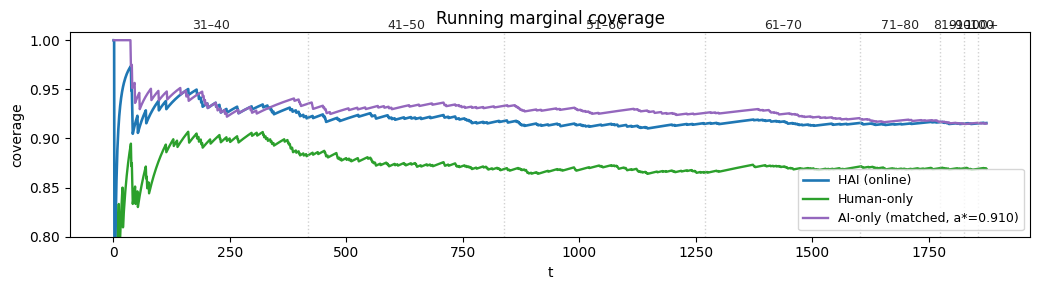

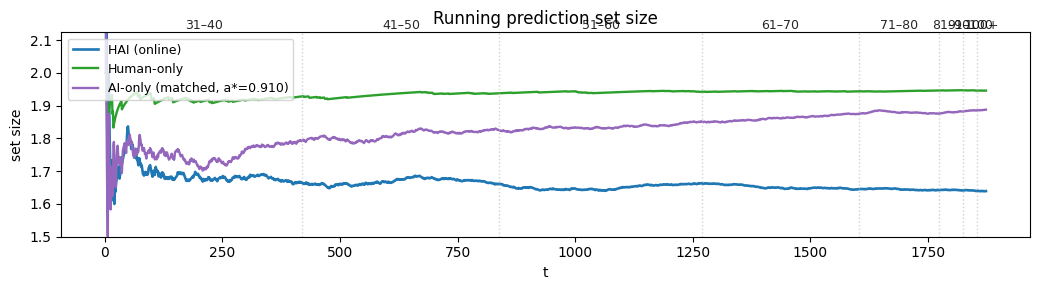

In [27]:

plot_cumulative_means(
    P,
    ylim_cov=(0.80, 1.0),
    ylim_size=(1.5, 2.1),
)
